
Training with learning rate = 1e-05
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step


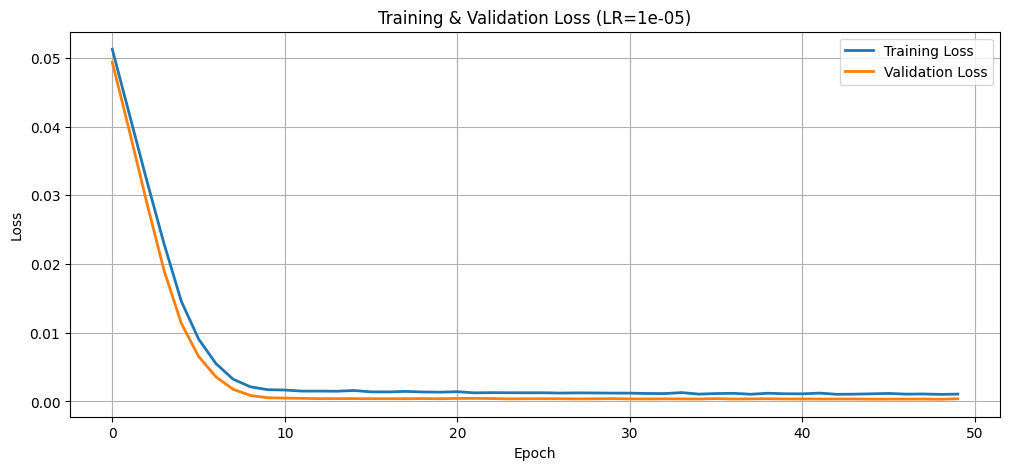

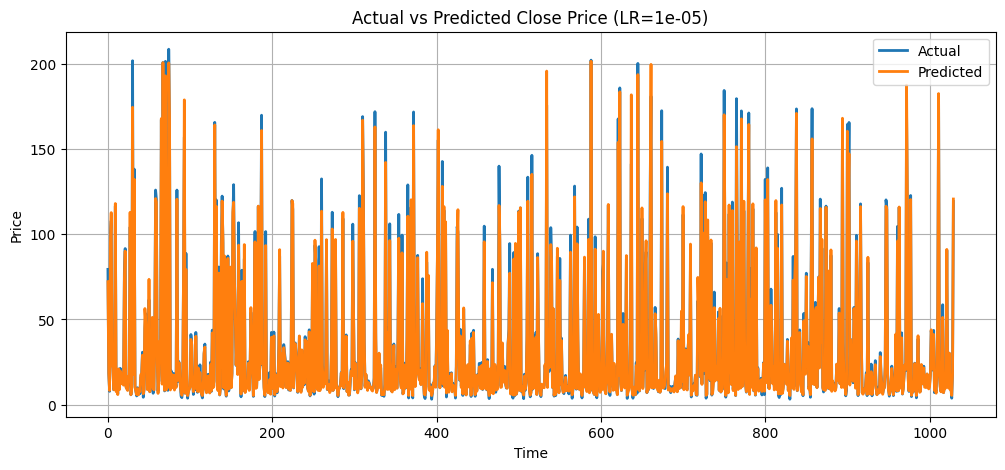


Training with learning rate = 0.0001
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step


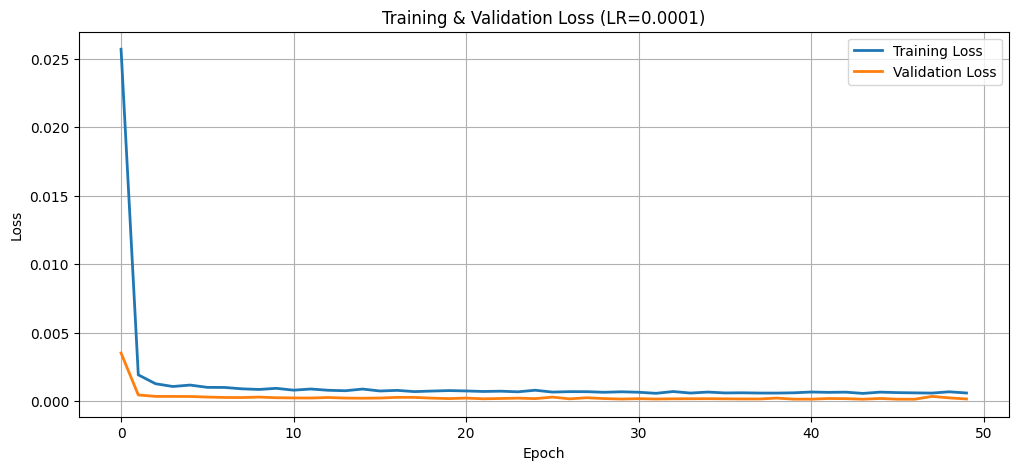

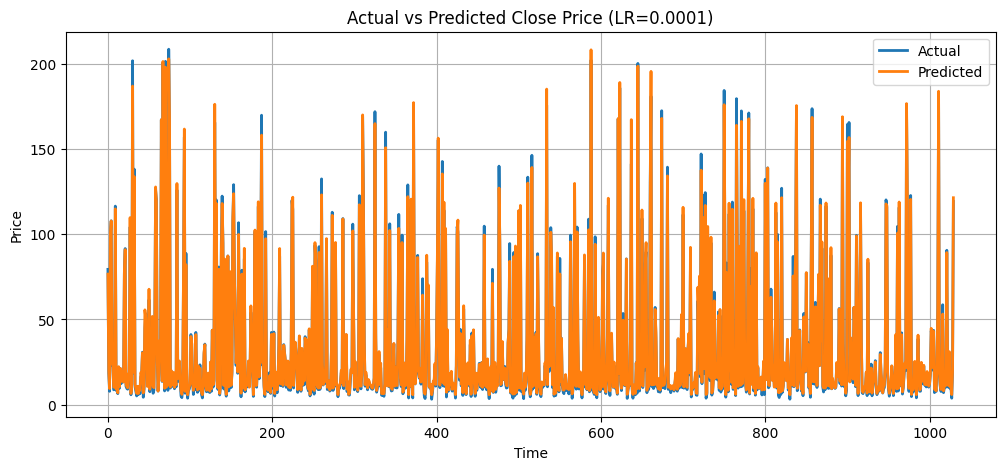


Training with learning rate = 0.001
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step


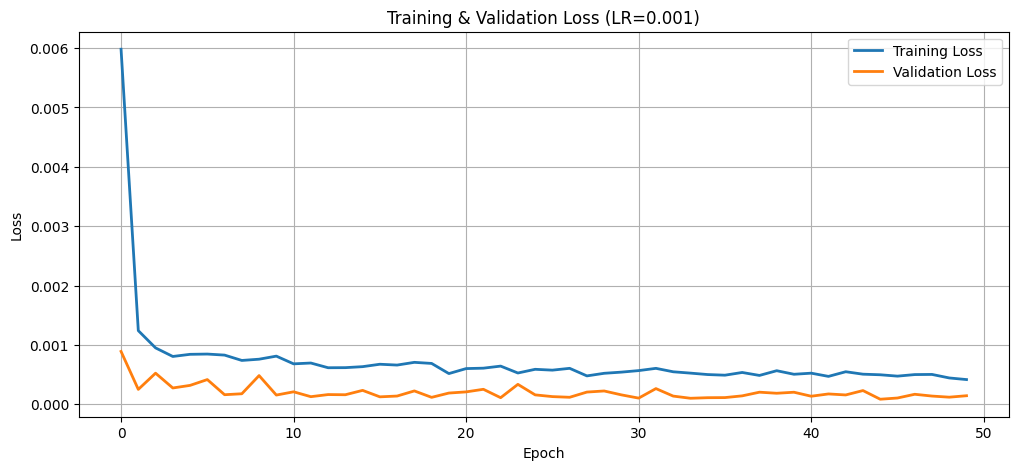

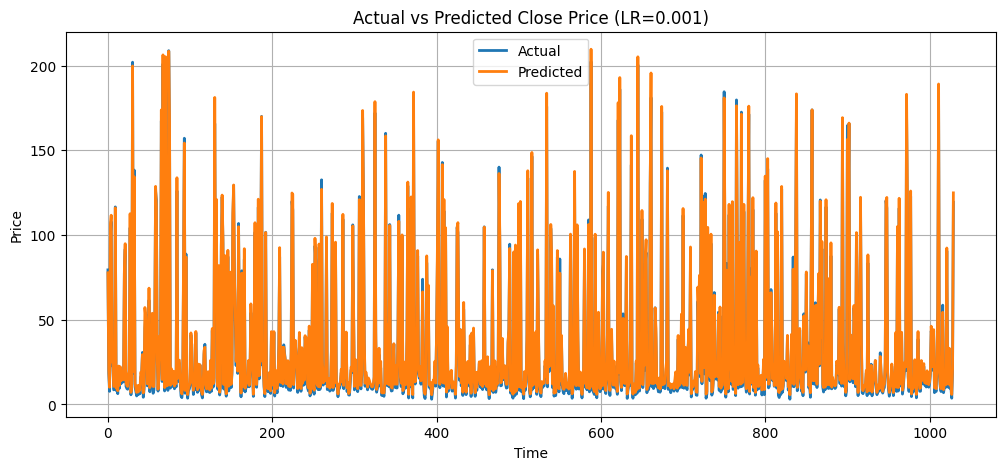


Training with learning rate = 0.01
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step


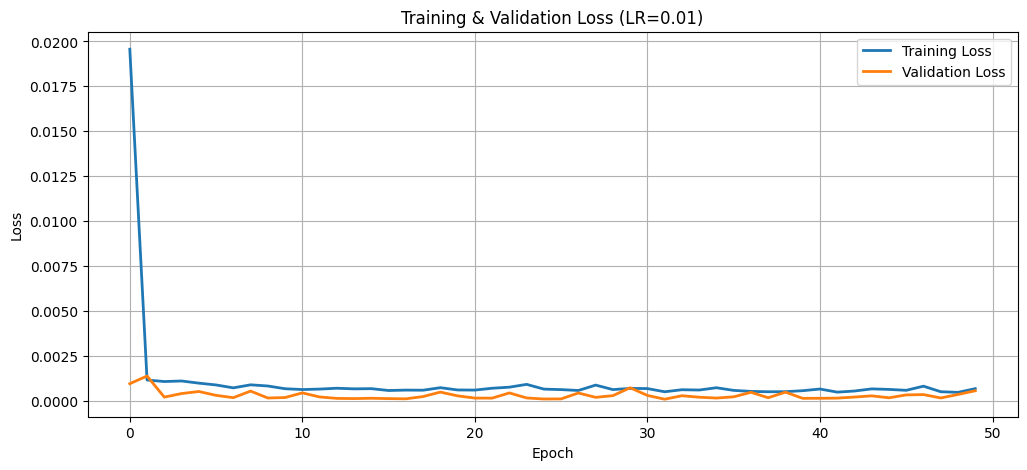

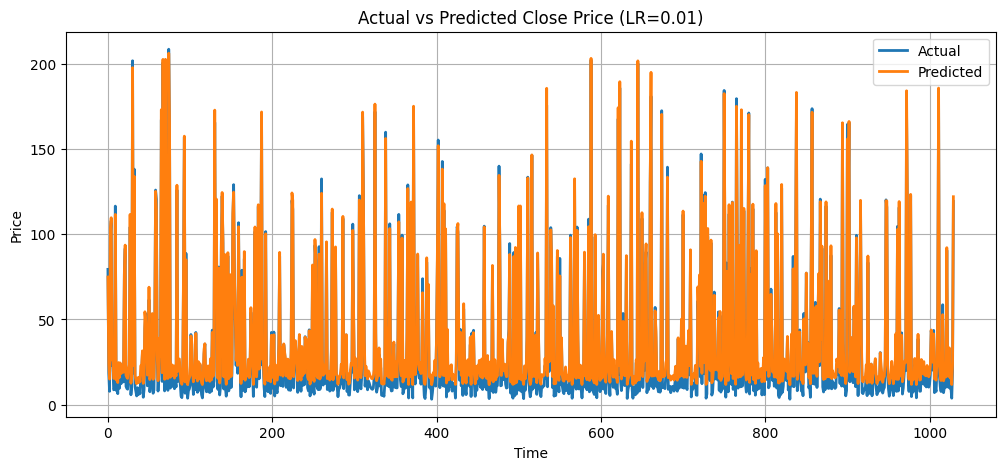


Evaluation Metrics Summary:
   Learning Rate      RMSE       MAE  R-squared
0        0.00001  4.415697  2.215984   0.988582
1        0.00010  2.842613  1.812428   0.995268
2        0.00100  2.936285  2.329310   0.994951
3        0.01000  5.478046  5.009458   0.982428


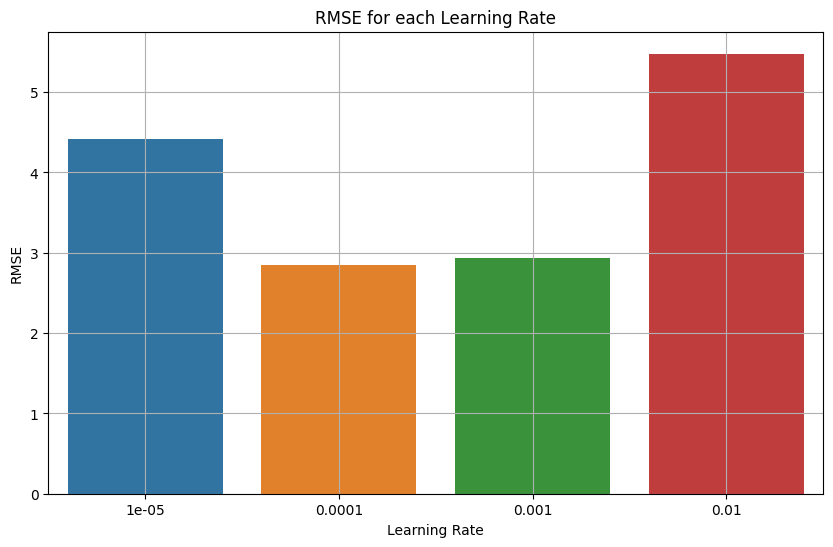

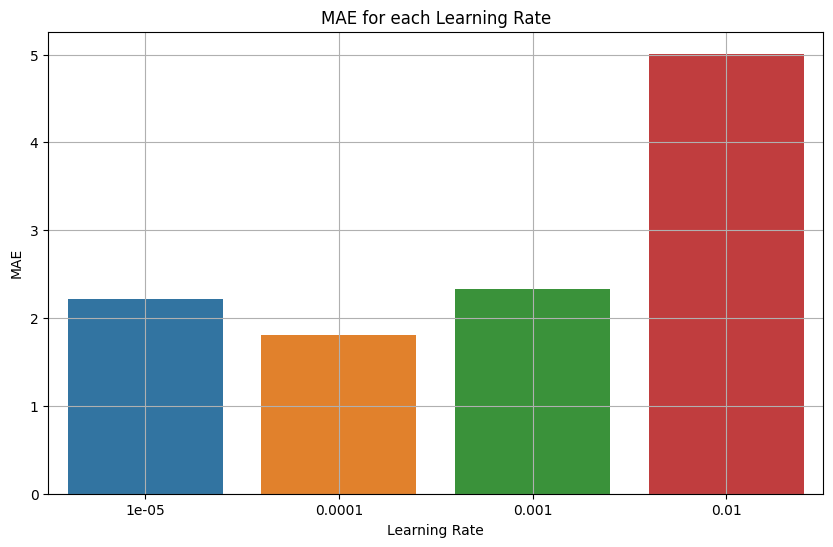

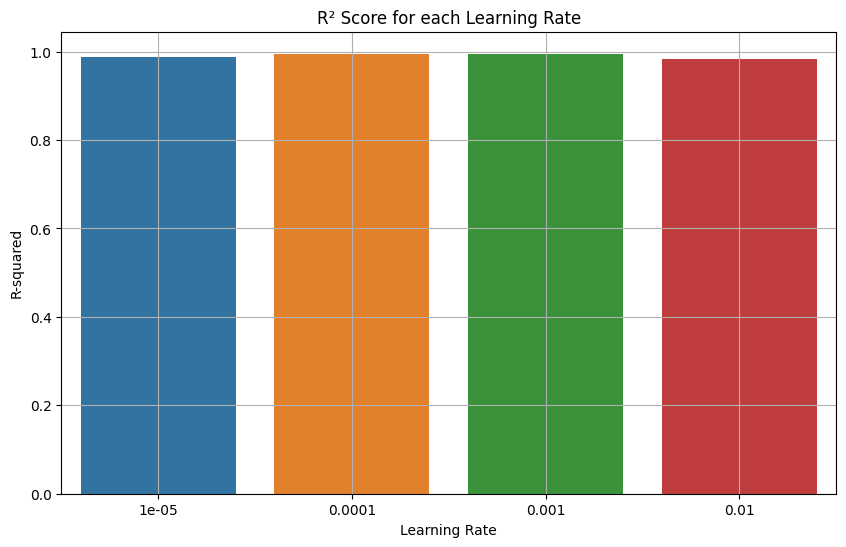

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, TimeDistributed, LSTM, Bidirectional
from keras.optimizers import Adam

# -------------------------------
#  Load and preprocess data
# -------------------------------
df = pd.read_csv("/kaggle/input/tsmc-stock-data-2025/TSM_1997-10-08_2025-04-22.csv")
df['date'] = pd.to_datetime(df['date'])

scaler = MinMaxScaler(feature_range=(0, 1))
data = df["close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)

def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)

# -------------------------------
#  Build CNN-BiLSTM model
# -------------------------------
def build_model(learning_rate):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(64, (1, 1), activation='relu'), input_shape=(look_back, 1, 1, 1)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
    model.add(TimeDistributed(Conv2D(128, (1, 1), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
    model.add(TimeDistributed(Conv2D(64, (1, 1), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# -------------------------------
#  Train & Evaluate
# -------------------------------
def train_and_evaluate(lr):
    model = build_model(lr)
    history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    return model, history, rmse, mae, r2, y_test_inv, y_pred_inv

# -------------------------------
#  Iterate over learning rates
# -------------------------------
learning_rates = [0.00001, 0.0001, 0.001, 0.01]
results = []

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model, history, rmse, mae, r2, y_test_inv, y_pred_inv = train_and_evaluate(lr)
    results.append((lr, rmse, mae, r2))

    # Plot 1: Loss Curve
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'Training & Validation Loss (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Actual vs Forecast
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv, label='Actual', linewidth=2)
    plt.plot(y_pred_inv, label='Predicted', linewidth=2)
    plt.title(f'Actual vs Predicted Close Price (LR={lr})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
#  Summary Table
# -------------------------------
results_df = pd.DataFrame(results, columns=['Learning Rate', 'RMSE', 'MAE', 'R-squared'])
print("\nEvaluation Metrics Summary:")
print(results_df)

# -------------------------------
#  Metrics Bar Plots
# -------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Learning Rate', y='RMSE', data=results_df)
plt.title("RMSE for each Learning Rate")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Learning Rate', y='MAE', data=results_df)
plt.title("MAE for each Learning Rate")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Learning Rate', y='R-squared', data=results_df)
plt.title("R² Score for each Learning Rate")
plt.grid(True)
plt.show()